In [2]:
import os
import glob
import pyart
import numpy as np
import xarray as xr
import wradlib as wrl
import cmweather as cm
from datetime import datetime

In [3]:
data_dir = "/Users/syed44/Downloads/SAMA_WORK/data/"
files = glob.glob(os.path.join(data_dir, "RSC*.nc"))
len(files)

1

In [4]:
def read_terls(file=None, outdir=None):
    '''TERLS Mosdac'''
    radar = pyart.io.read_cfradial(file)
    # Just open as simple xarray.Dataset, not decoding times
    vol = xr.open_dataset(file, decode_times=False)
    # 1./2.  fix time unit and time_coverage_start
    start_time = "".join(vol.time_coverage_start.astype(str).values)
    start_time = datetime.strptime(start_time, "%Y-%m-%dT%H:%M:%SZ")
    vol["time_coverage_start"] = start_time
    # time-units is wrong: "seconds since yyyy-mm-ddThh:mm:ssZ"
    vol["time"].attrs["units"] = f"seconds since {start_time}"
    radar.time['units'] = f"seconds since {start_time}"
    # now we can decode time (!)
    vol = xr.decode_cf(vol)
    ele = sorted(list(set(vol.elevation.values) ^ {0}))
    vele = vol.elevation
    sweep_start_ray_index = [vele.where(vele==el).argmin("time").values.item() for el in ele]
    sweep_end_ray_index = [vol.dims["time"] - 
                           vele.where(vele==el)[::-1].argmin("time").values.item() for el in ele]
    # vol["sweep_start_ray_index"].values = sweep_start_ray_index
    # vol["sweep_end_ray_index"].values = sweep_end_ray_index
    radar.sweep_start_ray_index['data'] = np.ma.masked_array(sweep_start_ray_index)
    radar.sweep_end_ray_index['data'] = np.ma.masked_array(sweep_end_ray_index)
    if outdir is None:
        outdir = "CFRADIAL"
    os.makedirs(outdir, exist_ok=True)
    outfile = os.path.join(outdir, os.path.basename(file))
    pyart.io.write_cfradial(outfile, radar=radar)
    print(f"Cfrad saved as {outfile}")
    return None

In [5]:
for file in files:
    read_terls(file=file, outdir="CFRADIAL")

/Users/syed44/miniconda3/envs/radar/lib/python3.12/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'gini' loading failed:
Struct() takes at most 1 argument (3 given)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


Cfrad saved as CFRADIAL/RSCHR_01APR2022_003424_L2B_STD.nc


In [6]:
ls CFRADIAL/

RSCHR_01APR2022_003424_L2B_STD.nc


In [7]:
radar = pyart.io.read_cfradial("CFRADIAL/RSCHR_01APR2022_003424_L2B_STD.nc")

In [8]:
display = pyart.graph.RadarDisplay(radar)

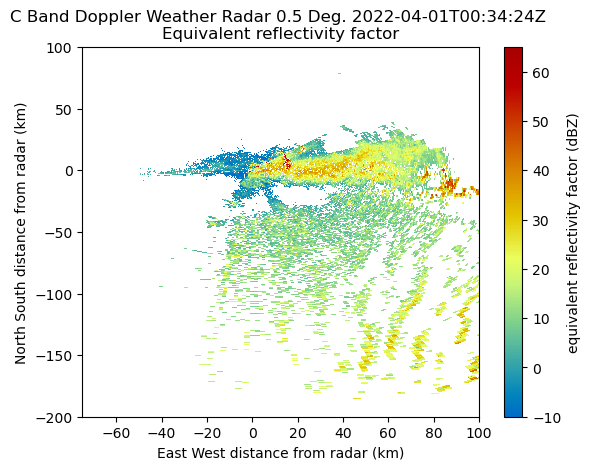

In [18]:
display.plot_ppi("DBZ", sweep=0)
display.set_limits(xlim=(-75, 100), ylim=(-200, 100))

In [19]:
import glob
import pathlib
import cartopy
import numpy as np
import xarray as xr
import xradar as xd
import wradlib as wrl
from osgeo import gdal
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
from matplotlib import ticker as tick

In [20]:
f = "CFRADIAL/RSCHR_01APR2022_003424_L2B_STD.nc"
vol = xd.io.open_cfradial1_datatree(f)

In [21]:
vol

DataTree('root', parent=None)
│   Dimensions:              (sweep: 10)
│   Dimensions without coordinates: sweep
│   Data variables:
│       sweep_group_name     (sweep) <U7 'sweep_0' 'sweep_1' ... 'sweep_8' 'sweep_9'
│       sweep_fixed_angle    (sweep) float32 ...
│       latitude             float64 ...
│       longitude            float64 ...
│       altitude             float64 ...
│       time_coverage_start  |S32 ...
│       time_coverage_end    |S32 ...
│       volume_number        int32 ...
│       platform_type        |S32 ...
│       instrument_type      |S32 ...
│       primary_axis         |S32 ...
│   Attributes:
│       Conventions:      CF
│       version:          Version 1.3
│       title:            C Band DWR data
│       institution:      ISRO
│       references:       
│       source:           DWR volume scan data
│       comment:          
│       instrument_name:  C Band Doppler Weather Radar
│       history:          DWR data encoded into CF compliant NetCDF
├── DataTree('radar_parameters')
├── DataTree('georeferencing_correction')
├── DataTree('sweep_0')
│       Dimensions:            (azimuth: 360, range: 1600)
│       Coordinates:
│           time               (azimuth) datetime64[ns] 2022-04-01T00:34:24.055555555...
│         * range              (range) float64 75.0 225.0 375.0 ... 2.398e+05 2.399e+05
│           elevation          (azimuth) float32 ...
│         * azimuth            (azimuth) float32 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
│           latitude           float64 ...
│           longitude          float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZ                (azimuth, range) float32 ...
│           VEL                (azimuth, range) float32 ...
│           WIDTH              (azimuth, range) float32 ...
│           ZDR                (azimuth, range) float32 ...
│           PHIDP              (azimuth, range) float32 ...
│           RHOHV              (azimuth, range) float32 ...
│           sweep_number       int32 ...
│           sweep_fixed_angle  float32 ...
│           sweep_mode         <U20 'azimuth surveillance'
├── DataTree('sweep_1')
│       Dimensions:            (azimuth: 360, range: 1600)
│       Coordinates:
│           time               (azimuth) datetime64[ns] 2022-04-01T00:35:04.055555555...
│         * range              (range) float64 75.0 225.0 375.0 ... 2.398e+05 2.399e+05
│           elevation          (azimuth) float32 ...
│         * azimuth            (azimuth) float32 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
│           latitude           float64 ...
│           longitude          float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZ                (azimuth, range) float32 ...
│           VEL                (azimuth, range) float32 ...
│           WIDTH              (azimuth, range) float32 ...
│           ZDR                (azimuth, range) float32 ...
│           PHIDP              (azimuth, range) float32 ...
│           RHOHV              (azimuth, range) float32 ...
│           sweep_number       int32 ...
│           sweep_fixed_angle  float32 ...
│           sweep_mode         <U20 'azimuth surveillance'
├── DataTree('sweep_2')
│       Dimensions:            (azimuth: 360, range: 1600)
│       Coordinates:
│           time               (azimuth) datetime64[ns] 2022-04-01T00:35:44.055555555...
│         * range              (range) float64 75.0 225.0 375.0 ... 2.398e+05 2.399e+05
│           elevation          (azimuth) float32 ...
│         * azimuth            (azimuth) float32 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
│           latitude           float64 ...
│           longitude          float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZ                (azimuth, range) float32 ...
│           VEL                (azimuth, range) float32 ...
│           WIDTH              (azimuth, range) float32 ...
│           ZDR   

In [22]:
from IPython.display import display

In [23]:
# Elevations
vol.root.sweep_fixed_angle.values

array([ 0.5,  1. ,  2. ,  3. ,  4.5,  6. ,  9. , 12. , 16. , 21. ],
      dtype=float32)

In [24]:
vol['sweep_0'].azimuth.shape, vol['sweep_0'].range.shape

((360,), (1600,))

In [25]:
vol['sweep_0'].range.diff(dim='range').median().values

array(150.)

In [26]:
nrays, nbins = vol['sweep_0'].azimuth.shape, vol['sweep_0'].range.shape
range_res = vol['sweep_0'].range.diff(dim='range').median().values

In [27]:
# nrays = 360
# nbins = 1600
# range_res = 150
ranges = np.arange(nbins[0]) * range_res
elevs = vol.root.sweep_fixed_angle.values
sitecoords = (
    vol.root.longitude.values.item(),
    vol.root.latitude.values.item(),
    vol.root.altitude.values.item(),
)

beamwidth = 1.0 # this is unfortunately not in the volume, we need to know this from somewhere else

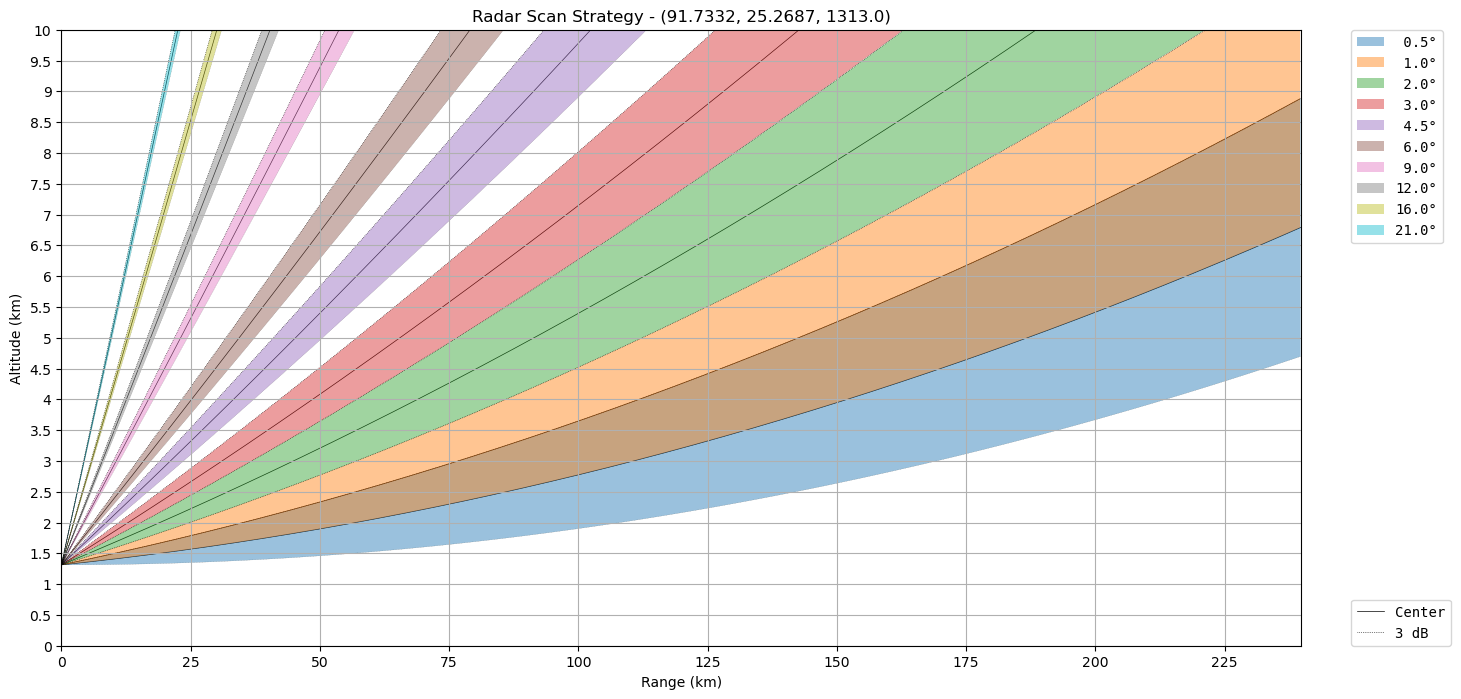

In [28]:
ax = wrl.vis.plot_scan_strategy(ranges, elevs, sitecoords, units="km")

Go to https://urs.earthdata.nasa.gov/profile, and click generate token, and paste it here in ""

In [29]:
import os
os.environ["WRADLIB_EARTHDATA_BEARER_TOKEN"] = "Get token from https://urs.earthdata.nasa.gov/"
os.environ["WRADLIB_DATA"] = "/Users/syed44/Git_Stuff/geo/"

In [31]:
# [wrl.util.get_wradlib_data_file(f) for f in flist]
xyz, rad = wrl.georef.spherical_to_xyz(ranges, [10.0], elevs, sitecoords, squeeze=True)
ll = wrl.georef.reproject(xyz, src_crs=rad)

# (down-)load srtm data
ds = wrl.io.get_srtm(
    [ll[..., 0].min(), ll[..., 0].max(), ll[..., 1].min(), ll[..., 1].max()],
)
rastervalues, rastercoords, proj = wrl.georef.extract_raster_dataset(
    ds, nodata=-32768.0
)
# map rastervalues to polar grid points
terrain = wrl.ipol.cart_to_irregular_spline(
    rastercoords, rastervalues, ll[-1, ..., :2], order=3, prefilter=False
)

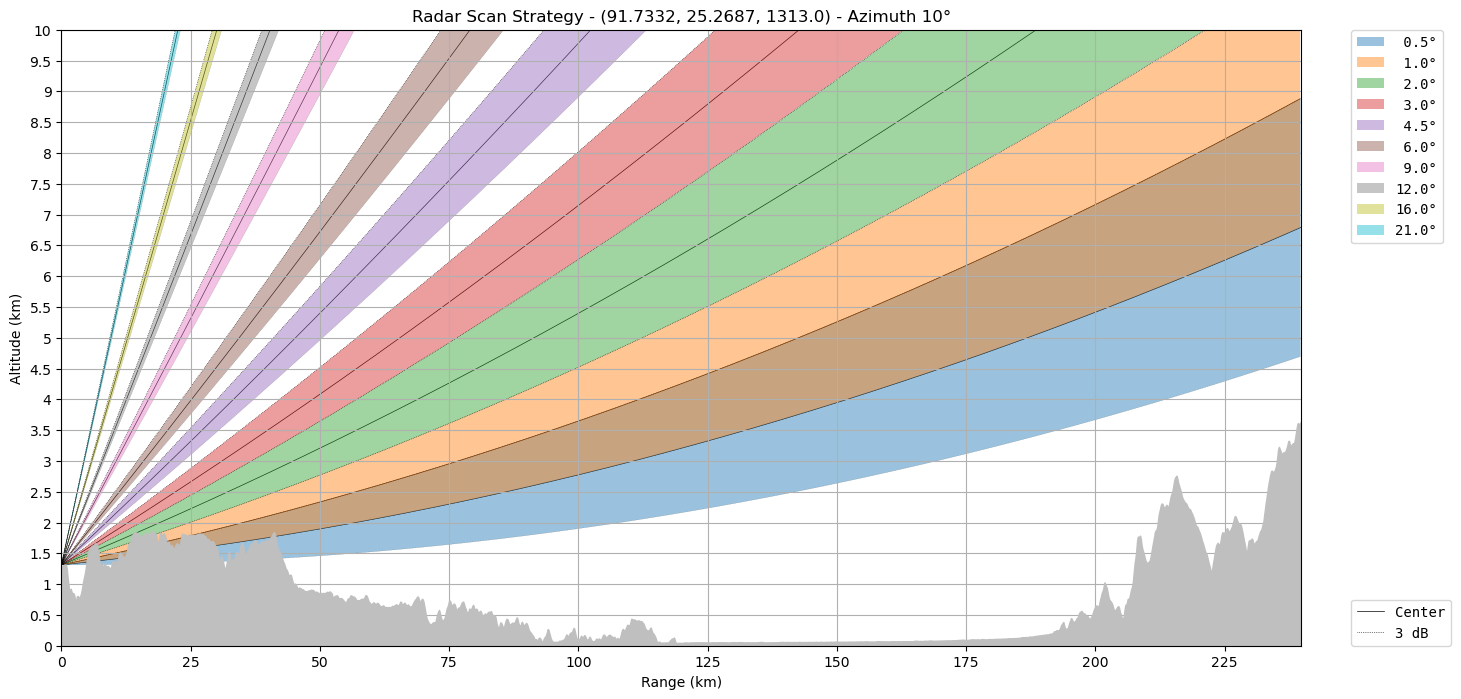

In [32]:
ax = wrl.vis.plot_scan_strategy(
        ranges, elevs, sitecoords, units="km", terrain=True, az=10)

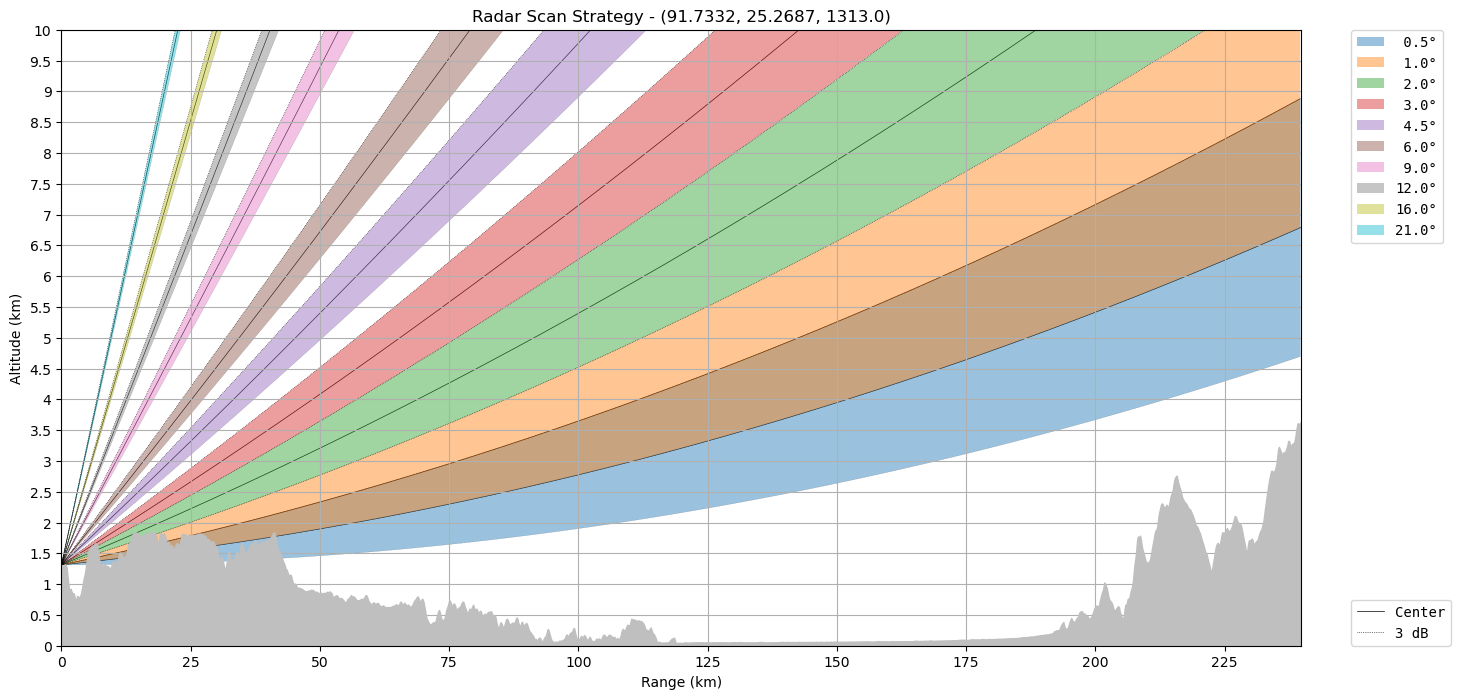

In [35]:
ax = wrl.vis.plot_scan_strategy(
        ranges, elevs, sitecoords, units="km", terrain=terrain, az=10)

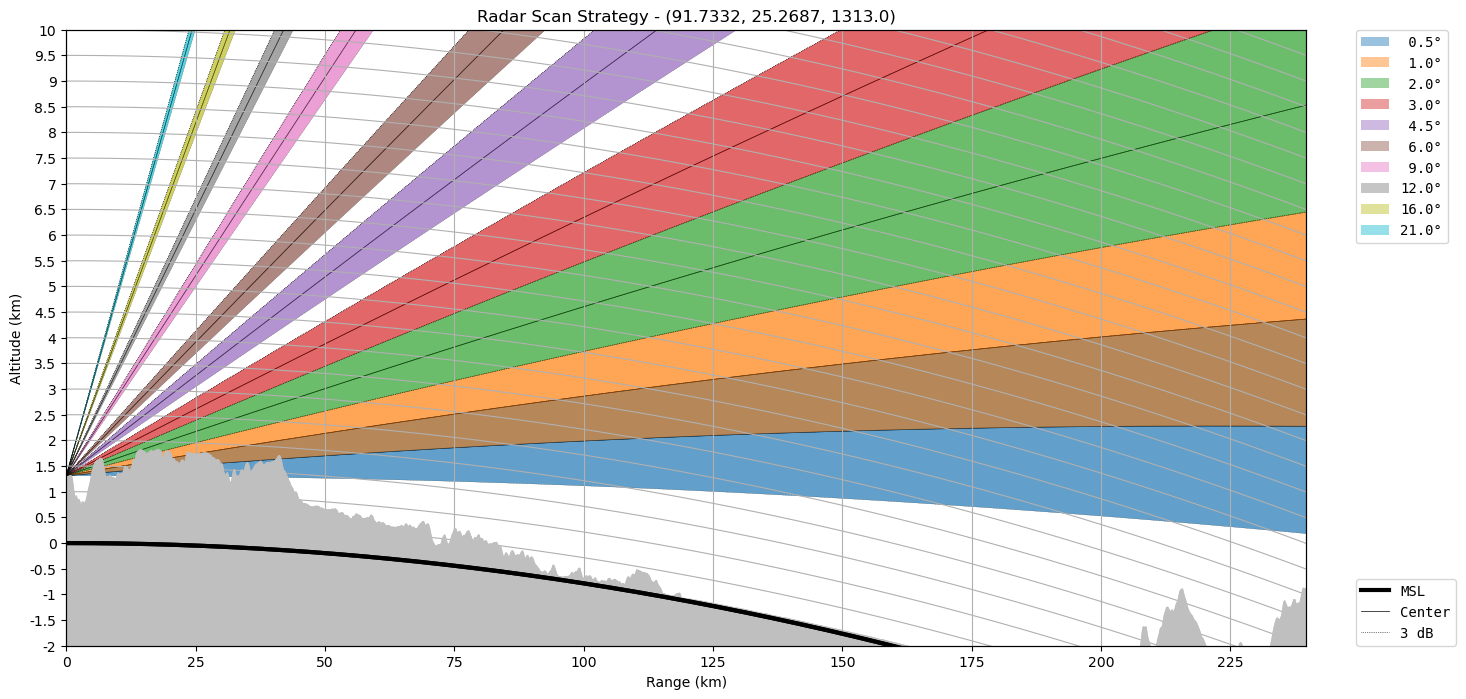

In [44]:
ax = wrl.vis.plot_scan_strategy(
        ranges, elevs, sitecoords, units="km", cg=True, terrain=terrain, az=90)